# BTC Trading Strategy with Ichimoku, EOM, Keltner Channels Period: 2022-01-01 to 2025-01-01


In [21]:
# import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:
#1. Data Download
data = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01")
data.dropna(inplace=True)
data.head()


/tmp/ipython-input-1869910300.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("BTC-USD", start="2022-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2022-01-01,47686.812500,47827.312500,46288.484375,46311.746094,24582667004
2022-01-02,47345.218750,47881.406250,46856.937500,47680.925781,27951569547
2022-01-03,46458.117188,47510.726562,45835.964844,47343.542969,33071628362
2022-01-04,45897.574219,47406.546875,45752.464844,46458.851562,42494677905
2022-01-05,43569.003906,46929.046875,42798.222656,45899.359375,36851084859


In [23]:
#2. Indicator Calculation
# Ichimoku Cloud (momentum), Ease of Movement (volume), Keltner Channels (volatility)

high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

# Ichimoku parameters (standard)
tenkan_period = 9
kijun_period = 26
senkou_span_b_period = 52
displacement = 26

# Tenkan-sen
data["tenkan"] = (high.rolling(tenkan_period).max() +
                  low.rolling(tenkan_period).min()) / 2

# Kijun-sen
data["kijun"] = (high.rolling(kijun_period).max() +
                 low.rolling(kijun_period).min()) / 2

# Senkou Span A
data["senkou_a"] = ((data["tenkan"] + data["kijun"]) / 2).shift(displacement)

# Senkou Span B
data["senkou_b"] = ((high.rolling(senkou_span_b_period).max() +
                     low.rolling(senkou_span_b_period).min()) / 2).shift(displacement)

# Ease of Movement (EOM)
distance = ((high + low) / 2) - ((high.shift(1) + low.shift(1)) / 2)
box_ratio = (volume / 1e8) / (high - low)
data["EOM"] = distance / box_ratio
data["EOM_14"] = data["EOM"].rolling(14).mean()

# Keltner Channels
ema_period = 20
atr_period = 14
multiplier = 2

data["EMA"] = close.ewm(span=ema_period, adjust=False).mean()

tr1 = high - low
tr2 = (high - close.shift(1)).abs()
tr3 = (low - close.shift(1)).abs()
true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
data["ATR"] = true_range.rolling(atr_period).mean()

data["UpperKC"] = data["EMA"] + multiplier * data["ATR"]
data["LowerKC"] = data["EMA"] - multiplier * data["ATR"]

data.dropna(inplace=True)
data.head()


Price,Close,High,Low,Open,Volume,tenkan,kijun,senkou_a,senkou_b,EOM,EOM_14,EMA,ATR,UpperKC,LowerKC
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2022-03-19,42190.652344,42316.554688,41602.667969,41794.648438,19664853187,39998.644531,39768.398438,40727.037109,40532.732422,2579.446666,1470.575837,40311.070873,1774.976562,43861.023998,36761.117748
2022-03-20,41247.824219,42241.164062,41004.757812,42191.406250,20127946682,39998.644531,39768.398438,40757.108398,40532.732422,-2067.953844,1449.873489,40400.285478,1761.253627,43922.792732,36877.778223
2022-03-21,41077.996094,41454.410156,40668.042969,41246.132812,24615543271,39998.644531,39768.398438,40798.215820,40347.392578,-1794.514449,1637.004598,40464.829346,1662.421038,43789.671422,37139.987270
2022-03-22,42358.808594,43124.707031,40948.281250,41074.105469,32004652376,40402.720703,41168.890625,39789.471680,40295.302734,6632.152962,2004.084713,40645.208322,1721.661830,44088.531983,37201.884661
2022-03-23,42892.957031,42893.507812,41877.507812,42364.378906,25242943069,40717.458984,41168.890625,39678.145508,40056.552734,1404.740682,478.268362,40859.279628,1525.691964,43910.663556,37807.895699


In [24]:
#3. Signal Generation
# Buy: price above cloud, EOM positive, price above UpperKC
# Sell: price below cloud, EOM negative, price below LowerKC

n = len(data)

close_arr = data["Close"].to_numpy().reshape(n, 1)
upperkc = data["UpperKC"].to_numpy().reshape(n, 1)
lowerkc = data["LowerKC"].to_numpy().reshape(n, 1)
eom = data["EOM_14"].to_numpy().reshape(n, 1)
senkou_a = data["senkou_a"].to_numpy().reshape(n, 1)
senkou_b = data["senkou_b"].to_numpy().reshape(n, 1)

signal = np.zeros(n, dtype=int)

buy_condition = (
    (close_arr > senkou_a) &
    (close_arr > senkou_b) &
    (close_arr > upperkc) &
    (eom > 0)
)

sell_condition = (
    (close_arr < senkou_a) &
    (close_arr < senkou_b) &
    (close_arr < lowerkc) &
    (eom < 0)
)

signal[buy_condition.flatten()] = 1
signal[sell_condition.flatten()] = -1

data["signal"] = signal
data[["Close", "signal"]].head()


Price,Close,signal
Ticker,BTC-USD,
Date,,
2022-03-19,42190.652344,0
2022-03-20,41247.824219,0
2022-03-21,41077.996094,0
2022-03-22,42358.808594,0
2022-03-23,42892.957031,0


In [25]:
#4. Risk Management: Stop-loss & Take-profit
# Simple 5% stop-loss and 10% take-profit from entry price

stop_loss = 0.05
take_profit = 0.10

close_prices = data["Close"].values
signals = data["signal"].values

entry_price = 0.0
in_position = False
exit_signal = np.zeros(n, dtype=int)

for i in range(n):
    if signals[i] == 1 and not in_position:
        entry_price = close_prices[i]
        in_position = True
    elif in_position:
        price_change = (close_prices[i] - entry_price) / entry_price
        if price_change <= -stop_loss or price_change >= take_profit or signals[i] == -1:
            exit_signal[i] = -1
            in_position = False

data["exit_signal"] = exit_signal
data[["signal", "exit_signal"]].head()


Price,signal,exit_signal
Ticker,,
Date,,
2022-03-19,0,0
2022-03-20,0,0
2022-03-21,0,0
2022-03-22,0,0
2022-03-23,0,0


In [26]:
#5. Position Column
# 1 when in trade, 0 when flat

position = np.zeros(n, dtype=int)

for i in range(n):
    if data["signal"].iloc[i] == 1 and (position[i-1] if i > 0 else 0) == 0:
        position[i] = 1
    elif data["exit_signal"].iloc[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1] if i > 0 else 0

data["position"] = position
data[["signal", "exit_signal", "position"]].head()


Price,signal,exit_signal,position
Ticker,,,
Date,,,
2022-03-19,0,0,0
2022-03-20,0,0,0
2022-03-21,0,0,0
2022-03-22,0,0,0
2022-03-23,0,0,0


In [27]:
#6. Backtesting
initial_capital = 100000

data["market_returns"] = data["Close"].pct_change()
data["strategy_returns"] = data["position"].shift(1) * data["market_returns"]

data.dropna(inplace=True)

data["portfolio_value"] = initial_capital * (1 + data["strategy_returns"]).cumprod()
final_value = data["portfolio_value"].iloc[-1] if len(data) > 0 else initial_capital
net_profit = final_value - initial_capital

print("Final Portfolio Value:", round(final_value, 2))
print("Net Profit:", round(net_profit, 2))


Final Portfolio Value: 221205.63
Net Profit: 121205.63


In [28]:
#7. Performance Metrics

returns = data["strategy_returns"].values
risk_free_rate = 0.01 / 252  # ~1% annual risk-free, daily

mean_return = returns.mean()
std_return = returns.std()

# sharpe ratio
sharpe_ratio = (mean_return - risk_free_rate) / std_return * np.sqrt(252) if std_return != 0 else 0
print("Sharpe Ratio:", round(sharpe_ratio, 2))

# Sortino Ratio
downside_returns = returns[returns < 0]
if len(downside_returns) > 0 and downside_returns.std() != 0:
    sortino_ratio = (mean_return - risk_free_rate) / downside_returns.std() * np.sqrt(252)
else:
    sortino_ratio = 0
print("Sortino Ratio:", round(sortino_ratio, 2))

# Maximum Drawdown
rolling_max = data["portfolio_value"].cummax()
drawdown = (data["portfolio_value"] - rolling_max) / rolling_max
max_drawdown = drawdown.min() * 100
print("Maximum Drawdown (%):", round(max_drawdown, 2))


Sharpe Ratio: 0.96
Sortino Ratio: 0.89
Maximum Drawdown (%): -21.33


In [29]:
#8. Trade Stats: Winning and Losing Trades

trade_returns = data.loc[data["exit_signal"] == -1, "strategy_returns"]

winning_trades = (trade_returns > 0).sum()
losing_trades = (trade_returns < 0).sum()
total_trades = winning_trades + losing_trades

win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0

print("Total Trades:", total_trades)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Win Rate (%):", round(win_rate, 2))


Total Trades: 23
Winning Trades: 13
Losing Trades: 10
Win Rate (%): 56.52


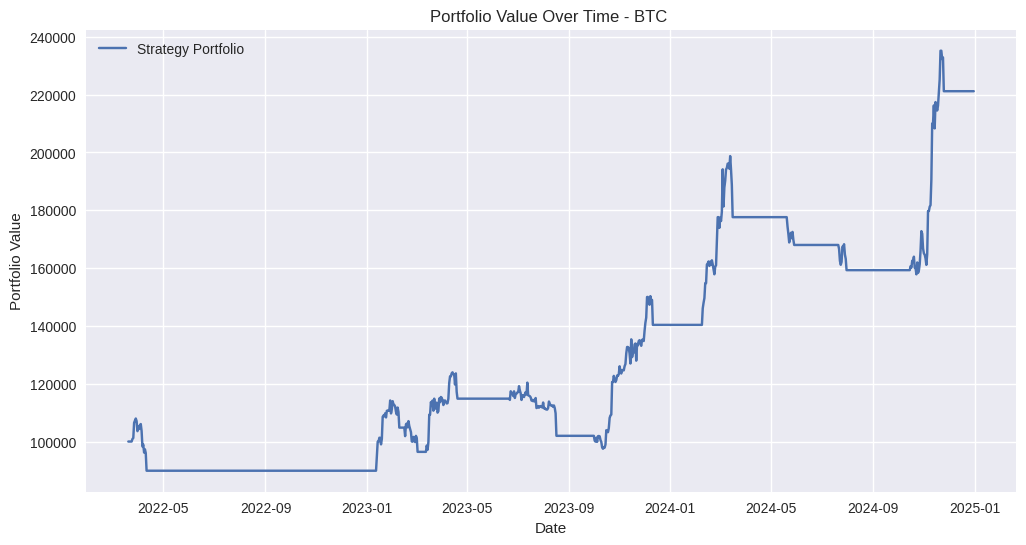

In [30]:
#9. Plot Portfolio Value

plt.figure(figsize=(12, 6))
plt.plot(data["portfolio_value"], label="Strategy Portfolio")
plt.title("Portfolio Value Over Time - BTC ")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
